In [1]:
import pychrono as chrono
import pychrono.vehicle as veh
import pychrono.irrlicht as chronoirr
import numpy as np
import os
import random
import math

from verti_bench.envs.utils.utils import SetChronoDataDirectories
import pychrono.sensor as sens
from verti_bench.envs.utils.asset_utils import *

from PIL import Image, ImageDraw
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import copy
import yaml
import logging

import torch
import torch.nn as nn
import torchvision.transforms.functional as F
import torch.nn.parallel as parallel
from collections import defaultdict

Make sure no values for rocks are 255, we want this value as obstalces

In [2]:
base_dir = os.getcwd()

max_tmp = 0
for world_id in range(1, 101):
    terrain_file = f"{world_id}.bmp"
    terrain_path = os.path.join(base_dir, "../data/terrain_bitmaps/BenchMaps/sampled_maps/Worlds", terrain_file)
    
    try:
        with Image.open(terrain_path) as img:
            img = img.convert("L")
            pixel_values = list(img.getdata())
            max_value = max(pixel_values)
            if max_value > max_tmp:
                max_tmp = max_value 
            print(f"{terrain_file}: max value = {max_value}")
    except FileNotFoundError:
        print(f"Not found: {terrain_file}")

print(f"Max value: {max_tmp}")

1.bmp: max value = 106
2.bmp: max value = 103
3.bmp: max value = 104
4.bmp: max value = 111
5.bmp: max value = 109
6.bmp: max value = 95
7.bmp: max value = 113
8.bmp: max value = 109
9.bmp: max value = 112
10.bmp: max value = 101
11.bmp: max value = 110
12.bmp: max value = 106
13.bmp: max value = 98
14.bmp: max value = 95
15.bmp: max value = 110
16.bmp: max value = 92
17.bmp: max value = 106
18.bmp: max value = 102
19.bmp: max value = 108
20.bmp: max value = 106
21.bmp: max value = 108
22.bmp: max value = 96
23.bmp: max value = 98
24.bmp: max value = 107
25.bmp: max value = 112
26.bmp: max value = 119
27.bmp: max value = 103
28.bmp: max value = 102
29.bmp: max value = 97
30.bmp: max value = 104
31.bmp: max value = 114
32.bmp: max value = 108
33.bmp: max value = 103
34.bmp: max value = 106
35.bmp: max value = 111
36.bmp: max value = 107
37.bmp: max value = 100
38.bmp: max value = 95
39.bmp: max value = 102
40.bmp: max value = 95
41.bmp: max value = 114
42.bmp: max value = 105
43.bmp: ma

Plot histogram for each single world and all worlds

Processed pixels from 1.bmp
Processed pixels from 2.bmp
Processed pixels from 3.bmp
Processed pixels from 4.bmp
Processed pixels from 5.bmp
Processed pixels from 6.bmp
Processed pixels from 7.bmp
Processed pixels from 8.bmp
Processed pixels from 9.bmp
Processed pixels from 10.bmp
Processed pixels from 11.bmp
Processed pixels from 12.bmp
Processed pixels from 13.bmp
Processed pixels from 14.bmp
Processed pixels from 15.bmp
Processed pixels from 16.bmp
Processed pixels from 17.bmp
Processed pixels from 18.bmp
Processed pixels from 19.bmp
Processed pixels from 20.bmp
Processed pixels from 21.bmp
Processed pixels from 22.bmp
Processed pixels from 23.bmp
Processed pixels from 24.bmp
Processed pixels from 25.bmp
Processed pixels from 26.bmp
Processed pixels from 27.bmp
Processed pixels from 28.bmp
Processed pixels from 29.bmp
Processed pixels from 30.bmp
Processed pixels from 31.bmp
Processed pixels from 32.bmp
Processed pixels from 33.bmp
Processed pixels from 34.bmp
Processed pixels from 3

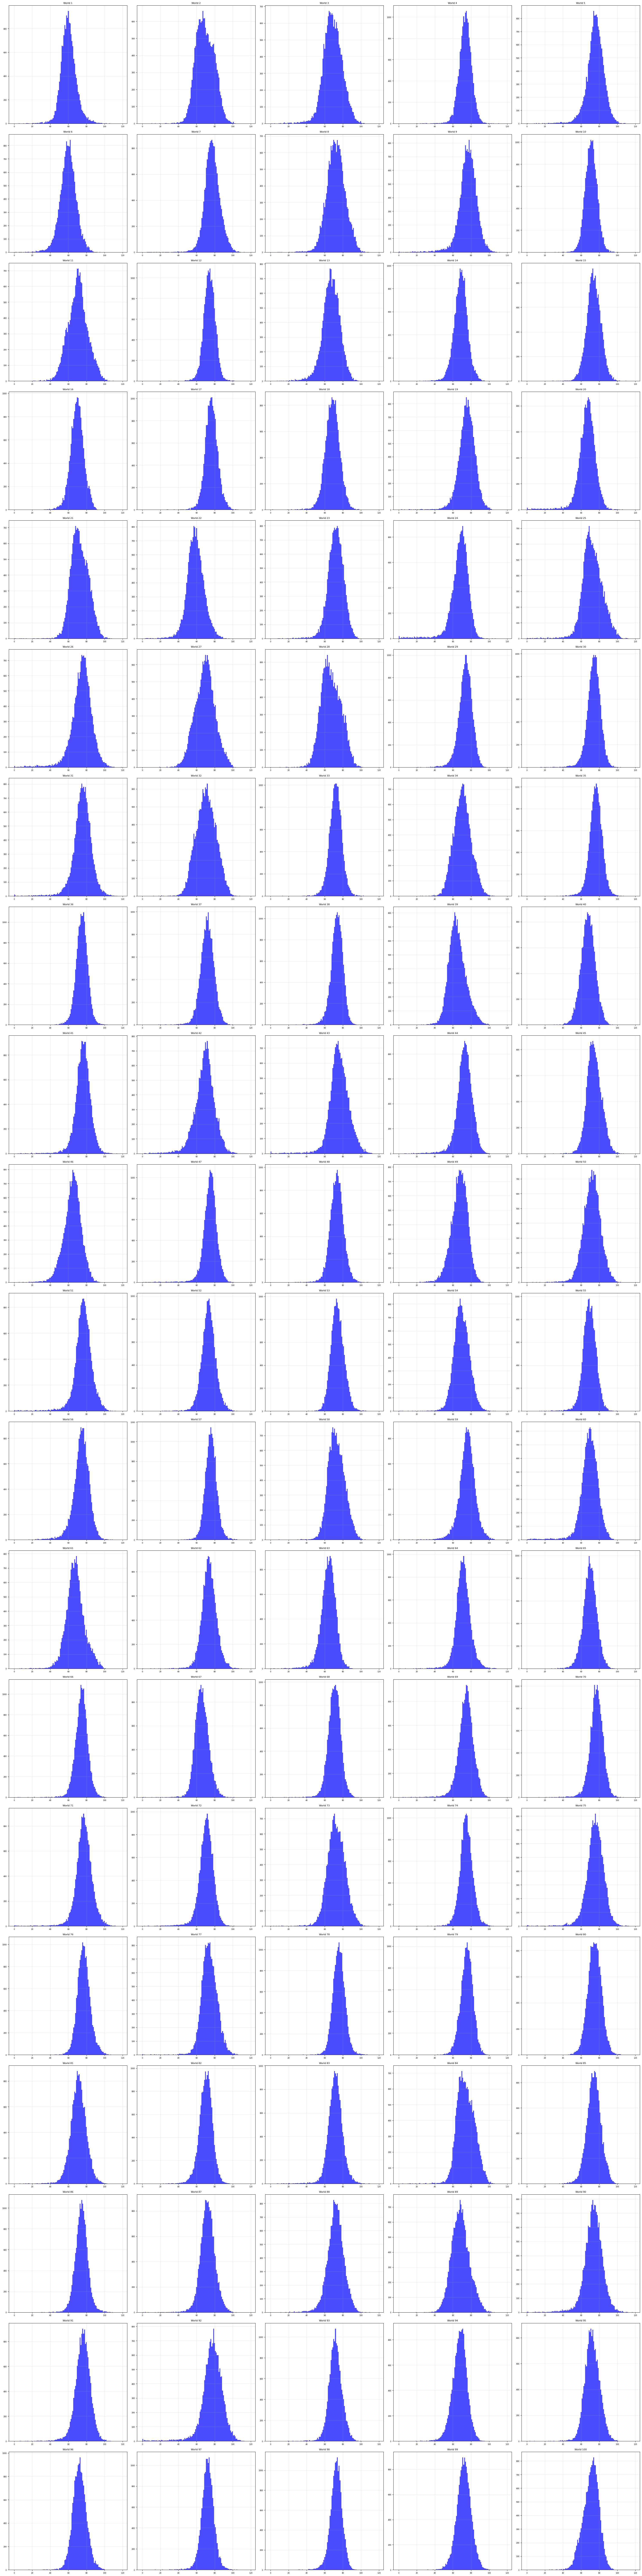

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def display_terrain_histograms(base_dir):
    fig, axes = plt.subplots(20, 5, figsize=(30, 120))

    for world_id in range(1, 101):
        terrain_file = f"{world_id}.bmp"
        terrain_path = os.path.join(base_dir, "../data/terrain_bitmaps/BenchMaps/sampled_maps/Worlds", terrain_file)
        
        try:
            with Image.open(terrain_path) as img:
                img = img.convert("L") 
                pixel_values = list(img.getdata())
                
                row = (world_id - 1) // 5 
                col = (world_id - 1) % 5
                
                axes[row, col].hist(pixel_values, bins=120, range=(0, 119), density=False, alpha=0.7, color='blue')
                axes[row, col].set_title(f'World {world_id}', fontsize=8) 
                axes[row, col].grid(True, alpha=0.3)
                axes[row, col].tick_params(axis='both', which='major', labelsize=6) 
            
            print(f"Processed pixels from {terrain_file}")
                
        except FileNotFoundError:
            print(f"Not found: {terrain_file}")
            axes[row, col].axis('off')  

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    base_dir = os.getcwd()
    display_terrain_histograms(base_dir)

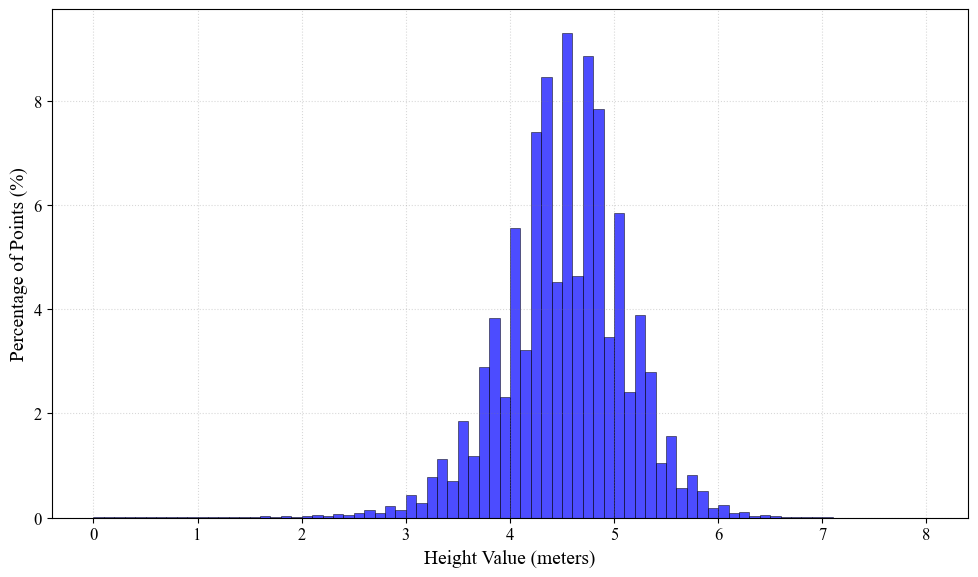

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def display_combined_histogram(base_dir):
    all_pixel_values = []

    for world_id in range(1, 101):
        terrain_file = f"{world_id}.bmp"
        terrain_path = os.path.join(base_dir, "../data/terrain_bitmaps/BenchMaps/sampled_maps/Worlds", terrain_file)
        
        try:
            with Image.open(terrain_path) as img:
                img = img.convert("L")  # Convert to grayscale
                pixel_values = list(img.getdata())
                # Convert pixel values from [0, 255] to [0, 16]
                pixel_values = [p * (16 / 255) for p in pixel_values]
                all_pixel_values.extend(pixel_values)
                
        except FileNotFoundError:
            print(f"Not found: {terrain_file}")

    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 14  # Increase base font size
    plt.rcParams['axes.titlesize'] = 16  # Title font size
    plt.rcParams['axes.labelsize'] = 14  # Axis label font size
    plt.rcParams['xtick.labelsize'] = 12  # X-axis tick labels
    plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick labels
   
    plt.figure(figsize=(10, 6))
    bin_edges = np.arange(0, 8.1, 0.1)
    
    weights = np.ones_like(all_pixel_values) / len(all_pixel_values) * 100
    counts, bins, patches = plt.hist(all_pixel_values, 
                                   bins=bin_edges,
                                   weights=weights,
                                   alpha=0.7, 
                                   color='blue',
                                   edgecolor='black',
                                   linewidth=0.5)
    
    # plt.title('Elevation Distribution for All Worlds', fontsize=16)
    plt.xlabel('Height Value (meters)', fontsize=14)
    plt.ylabel('Percentage of Points (%)', fontsize=14)
    plt.grid(True, alpha=0.3, linestyle=':', color='gray')
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    base_dir = os.getcwd()
    display_combined_histogram(base_dir)

Analysis elevation for easy, medium and hard worlds

In [6]:
import os
import glob

# Base directory
base_dir = os.getcwd()

# Path pattern for all config files
config_pattern = os.path.join(base_dir, "../data/terrain_bitmaps/BenchMaps/sampled_maps/configTest/Final", "config*.yaml")

# Find all matching config files
matched_files = glob.glob(config_pattern)

# Initialize lists to store grouped config files
low_configs = []
mid_configs = []
high_configs = []

# Categorize config files based on their filenames
for file_path in matched_files:
    filename = os.path.basename(file_path)  # Get the filename (e.g., "config1_low.yaml")
    if "_low" in filename:
        low_configs.append(file_path)
    elif "_mid" in filename:
        mid_configs.append(file_path)
    elif "_high" in filename:
        high_configs.append(file_path)

# Print the results
print(f"Low config files: {len(low_configs)}")
for file in low_configs:
    print(f"  {file}")

print(f"\nMid config files: {len(mid_configs)}")
for file in mid_configs:
    print(f"  {file}")

print(f"\nHigh config files: {len(high_configs)}")
for file in high_configs:
    print(f"  {file}")

Low config files: 35
  /home/tong/Documents/verti_bench/envs/utils/../data/terrain_bitmaps/BenchMaps/sampled_maps/configTest/Final/config80_low.yaml
  /home/tong/Documents/verti_bench/envs/utils/../data/terrain_bitmaps/BenchMaps/sampled_maps/configTest/Final/config24_low.yaml
  /home/tong/Documents/verti_bench/envs/utils/../data/terrain_bitmaps/BenchMaps/sampled_maps/configTest/Final/config54_low.yaml
  /home/tong/Documents/verti_bench/envs/utils/../data/terrain_bitmaps/BenchMaps/sampled_maps/configTest/Final/config55_low.yaml
  /home/tong/Documents/verti_bench/envs/utils/../data/terrain_bitmaps/BenchMaps/sampled_maps/configTest/Final/config94_low.yaml
  /home/tong/Documents/verti_bench/envs/utils/../data/terrain_bitmaps/BenchMaps/sampled_maps/configTest/Final/config98_low.yaml
  /home/tong/Documents/verti_bench/envs/utils/../data/terrain_bitmaps/BenchMaps/sampled_maps/configTest/Final/config48_low.yaml
  /home/tong/Documents/verti_bench/envs/utils/../data/terrain_bitmaps/BenchMaps/sam

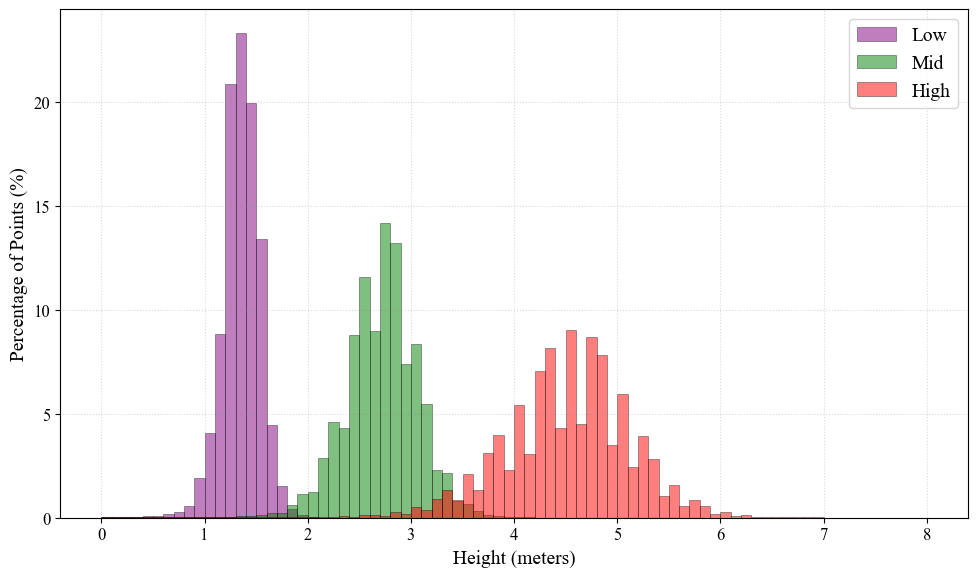

In [7]:
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def display_combined_histogram(base_dir, by_difficulty=True):
    # Configure matplotlib style
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12

    # Define elevation ranges and colors for different difficulties
    elevation_ranges = {
        'low': {'min_height': 0, 'max_height': 4.8},
        'mid': {'min_height': 0, 'max_height': 9.6},
        'high': {'min_height': 0, 'max_height': 16}
    }
    colors = {'low': 'purple', 'mid': 'green', 'high': 'red'}
    
    if by_difficulty:
        # Path pattern for config files
        config_pattern = os.path.join(base_dir, "../data/terrain_bitmaps/BenchMaps/sampled_maps/configTest/Final", "config*.yaml")
        matched_files = glob.glob(config_pattern)
        
        # Initialize data storage
        elevation_data = {group: [] for group in elevation_ranges.keys()}
        
        # Process files by difficulty
        for file_path in matched_files:
            filename = os.path.basename(file_path)
            difficulty = next((diff for diff in ['low', 'mid', 'high'] if f'_{diff}' in filename), None)
            if not difficulty:
                continue
                
            world_id = int(filename.split('_')[0].replace('config', ''))
            terrain_path = os.path.join(base_dir, "../data/terrain_bitmaps/BenchMaps/sampled_maps/Worlds", f"{world_id}.bmp")
            
            try:
                with Image.open(terrain_path) as img:
                    img = img.convert("L")
                    pixel_values = np.array(img.getdata())
                    min_height = elevation_ranges[difficulty]['min_height']
                    max_height = elevation_ranges[difficulty]['max_height']
                    chrono_heights = min_height + (pixel_values / 255) * (max_height - min_height)
                    elevation_data[difficulty].extend(chrono_heights)
            except (FileNotFoundError, IOError) as e:
                print(f"Error processing terrain file {world_id}.bmp: {e}")
        
        # Create plot
        plt.figure(figsize=(10, 6))
        bin_edges = np.arange(0, 8.1, 0.1)
        
        for difficulty in elevation_data:
            if elevation_data[difficulty]:  # Only plot if we have data
                weights = np.ones_like(elevation_data[difficulty]) / len(elevation_data[difficulty]) * 100
                plt.hist(elevation_data[difficulty],
                        bins=bin_edges,
                        weights=weights,
                        alpha=0.5,
                        label=f'{difficulty.capitalize()}',
                        color=colors[difficulty],
                        edgecolor='black',
                        linewidth=0.5)
        
        plt.legend(loc='upper right')
    else:
        # Original single histogram logic
        all_pixel_values = []
        for world_id in range(1, 101):
            terrain_path = os.path.join(base_dir, "../data/terrain_bitmaps/BenchMaps/sampled_maps/Worlds", f"{world_id}.bmp")
            try:
                with Image.open(terrain_path) as img:
                    img = img.convert("L")
                    pixel_values = np.array(img.getdata()) * (16 / 255)
                    all_pixel_values.extend(pixel_values)
            except (FileNotFoundError, IOError) as e:
                print(f"Error processing terrain file {world_id}.bmp: {e}")
        
        plt.figure(figsize=(10, 6))
        bin_edges = np.arange(0, 8.1, 0.1)
        weights = np.ones_like(all_pixel_values) / len(all_pixel_values) * 100
        plt.hist(all_pixel_values,
                bins=bin_edges,
                weights=weights,
                alpha=0.7,
                color='blue',
                edgecolor='black',
                linewidth=0.5)
    
    plt.xlabel('Height (meters)', fontsize=14)
    plt.ylabel('Percentage of Points (%)', fontsize=14)
    plt.grid(True, alpha=0.3, linestyle=':', color='gray')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    base_dir = os.getcwd()
    display_combined_histogram(base_dir, by_difficulty=True) 

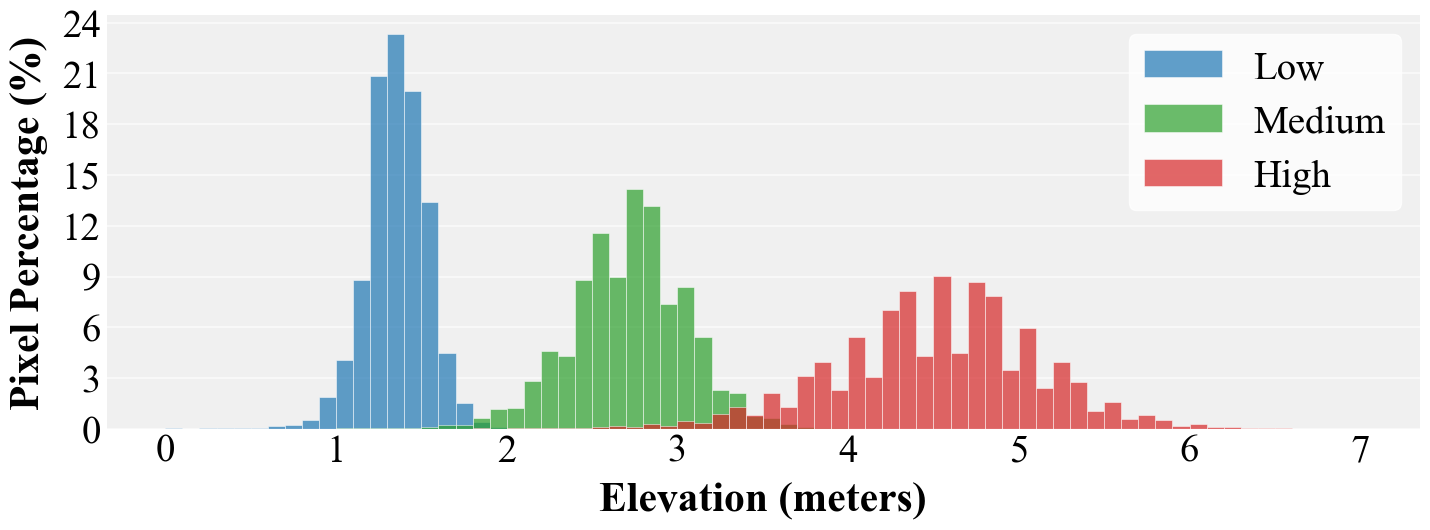

In [32]:
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MaxNLocator

def format_int(x, p):
    """Format numbers as integers"""
    return f"{int(x)}"

def display_combined_histogram(base_dir):
    # Configure matplotlib style
    plt.style.use('default')
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 30
    plt.rcParams['axes.titlesize'] = 30
    plt.rcParams['axes.labelsize'] = 30
    plt.rcParams['xtick.labelsize'] = 28  
    plt.rcParams['ytick.labelsize'] = 28  

    # Define elevation ranges
    elevation_ranges = {
        'low': {'min_height': 0, 'max_height': 4.8},
        'mid': {'min_height': 0, 'max_height': 9.6},
        'high': {'min_height': 0, 'max_height': 16}
    }
    
    colors = {
        'low': '#1F77B4',    # Blue
        'mid': '#2CA02C',    # Green
        'high': '#D62728',   # Red
        'combined': '#17BECF' # Cyan
    }
    
    # Initialize data storage
    elevation_data = {group: [] for group in elevation_ranges.keys()}
    combined_data = []
    
    # Get config files to map world_id to difficulty
    config_pattern = os.path.join(base_dir, "../data/terrain_bitmaps/BenchMaps/sampled_maps/configTest/Final", "config*.yaml")
    matched_files = glob.glob(config_pattern)
    
    # Create mapping of world_id to difficulty
    world_difficulty_map = {}
    for file_path in matched_files:
        filename = os.path.basename(file_path)
        difficulty = next((diff for diff in ['low', 'mid', 'high'] if f'_{diff}' in filename), None)
        if difficulty:
            world_id = int(filename.split('_')[0].replace('config', ''))
            world_difficulty_map[world_id] = difficulty
    
    # Process files by difficulty
    for world_id in range(1, 101):
        if world_id not in world_difficulty_map:
            continue
            
        difficulty = world_difficulty_map[world_id]
        terrain_path = os.path.join(base_dir, "../data/terrain_bitmaps/BenchMaps/sampled_maps/Worlds", f"{world_id}.bmp")
        
        try:
            with Image.open(terrain_path) as img:
                img = img.convert("L")
                pixel_values = np.array(img.getdata())
                min_height = elevation_ranges[difficulty]['min_height']
                max_height = elevation_ranges[difficulty]['max_height']
                real_heights = min_height + (pixel_values / 255) * (max_height - min_height)
                elevation_data[difficulty].extend(real_heights)
                combined_data.extend(real_heights)
        except (FileNotFoundError, IOError) as e:
            print(f"Error processing terrain file {world_id}.bmp: {e}")
    
    # Create figure with single subplot
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Set figure style
    fig.patch.set_facecolor('white')
    ax.set_facecolor('#F0F0F0')
    ax.tick_params(axis='both', length=0)
    
    bin_edges = np.arange(0, 7.1, 0.1)
    
    # Plot difficulty-specific distributions
    for difficulty in elevation_data:
        if elevation_data[difficulty]:
            weights = np.ones_like(elevation_data[difficulty]) / len(elevation_data[difficulty]) * 100
            ax.hist(elevation_data[difficulty],
                   bins=bin_edges,
                   weights=weights,
                   alpha=0.7,
                   label=difficulty.capitalize(),
                   color=colors[difficulty],
                   edgecolor='white',
                   linewidth=0.5)
    
    # Customize axes
    ax.yaxis.set_major_formatter(FuncFormatter(format_int))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Labels and title
    ax.set_xlabel('Elevation (meters)', weight='bold', labelpad=10)
    ax.set_ylabel('Pixel Percentage (%)', weight='bold', labelpad=10)
    
    # Grid and spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.yaxis.grid(True, linestyle='-', linewidth=1.5, alpha=0.6, color='white')
    ax.set_axisbelow(True)
    
    # Add legend to top right
    ax.legend(['Low', 'Medium', 'High'],
             loc='upper right',
             frameon=True,
             fontsize=28,
             edgecolor='white')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    base_dir = os.getcwd()
    display_combined_histogram(base_dir)

Analysis for percentage of semantics

In [9]:
import os
import glob
import yaml
from collections import defaultdict
import matplotlib.pyplot as plt

# Base directory and pattern
base_dir = os.getcwd()
config_pattern = os.path.join(base_dir, "../data/terrain_bitmaps/BenchMaps/sampled_maps/configTest/Final", "config*.yaml")
matched_files = glob.glob(config_pattern)

# Initialize counters
texture_counts = defaultdict(int)
terrain_type_counts = defaultdict(int)
total_textures = 0
total_configs = len(matched_files)

# Define texture types
rigid_types = ['clay', 'concrete', 'dirt', 'grass', 'gravel', 'rock', 'wood']
deformable_types = ['mud', 'sand', 'snow']

# For total distribution including mixed
total_rigid_count = 0
total_deform_count = 0

# Process each config file
for file_path in matched_files:
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
        
        # Count basic terrain types
        terrain_type = config['terrain_type']
        terrain_type_counts[terrain_type] += 1
        
        # Count textures and calculate true rigid/deformable distribution
        rigid_in_config = 0
        deform_in_config = 0
        
        textures = config['textures']
        for texture_info in textures:
            terrain_type = texture_info['terrain_type']
            is_deformable = texture_info['is_deformable']
            
            # Count individual texture types
            texture_counts[terrain_type] += 1
            total_textures += 1
            
            # Count as rigid or deformable
            if is_deformable:
                deform_in_config += 1
                total_deform_count += 1
            else:
                rigid_in_config += 1
                total_rigid_count += 1

# Calculate percentages
print("Original Terrain Type Distribution:")
print("-" * 50)
for terrain_type in terrain_type_counts:
    percentage = (terrain_type_counts[terrain_type] / total_configs) * 100
    print(f"{terrain_type}: {percentage:.2f}%")

print("\nTrue Rigid vs Deformable Distribution (including mixed):")
print("-" * 50)
total_all = total_rigid_count + total_deform_count
print(f"Rigid: {(total_rigid_count/total_all)*100:.2f}%")
print(f"Deformable: {(total_deform_count/total_all)*100:.2f}%")

print("\nDetailed Texture Distribution:")
print("-" * 50)
print("\nRigid Textures:")
for texture in rigid_types:
    percentage = (texture_counts[texture] / total_textures) * 100
    print(f"{texture}: {percentage:.2f}%")

print("\nDeformable Textures:")
for texture in deformable_types:
    percentage = (texture_counts[texture] / total_textures) * 100
    print(f"{texture}: {percentage:.2f}%")

# Visualization
plt.figure(figsize=(15, 5))

# # 1. Original terrain type distribution
# plt.subplot(131)
# terrain_labels = list(terrain_type_counts.keys())
# terrain_sizes = list(terrain_type_counts.values())
# plt.pie(terrain_sizes, labels=terrain_labels, autopct='%1.1f%%')
# plt.title('Original Terrain Type Distribution')

# # 2. True rigid/deformable distribution
# plt.subplot(132)
# true_dist = [total_rigid_count, total_deform_count]
# plt.pie(true_dist, labels=['Rigid', 'Deformable'], autopct='%1.1f%%')
# plt.title('True Rigid vs Deformable Distribution')

# 3. Individual texture distribution
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Create more compact figure
plt.figure(figsize=(12, 6), dpi=150) 

# Prepare data
labels = []
sizes = []
categories = []
for texture in rigid_types + deformable_types:
    if texture_counts[texture] > 0:
        labels.append(texture.capitalize())
        sizes.append((texture_counts[texture] / total_textures) * 100)
        categories.append('Rigid' if texture in rigid_types else 'Deformable')

# Create bar chart with custom colors
colors = ['#4169E1' if cat == 'Rigid' else '#FF4F4F' for cat in categories]
bars = plt.bar(labels, sizes, color=colors, alpha=0.75, width=0.6)  # Reduced bar width

# Add percentage labels more compactly
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,  # Reduced vertical offset
             f'{height:.1f}%',
             ha='center', va='bottom',
             fontsize=9,  # Reduced font size
             fontweight='bold',
             color='#303030')

# Customize the plot with more compact styling
plt.title('Distribution of Different Textures', 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Texture Types', fontsize=11, labelpad=8)
plt.ylabel('Percentage (%)', fontsize=11, labelpad=8)

# Lighter grid
plt.grid(True, linestyle='--', alpha=0.2, color='gray')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)

# Add more compact legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#4169E1', alpha=0.75, label='Rigid'),
    Patch(facecolor='#FF4F4F', alpha=0.75, label='Deformable')
]
plt.legend(handles=legend_elements, 
          loc='upper left',
          fontsize=9,
          frameon=True,
          facecolor='white',
          edgecolor='lightgray')

# Adjust layout
plt.tight_layout()

plt.show()

Original Terrain Type Distribution:
--------------------------------------------------
rigid: 60.00%
deformable: 30.00%
mixed: 10.00%

True Rigid vs Deformable Distribution (including mixed):
--------------------------------------------------
Rigid: 66.60%
Deformable: 33.40%

Detailed Texture Distribution:
--------------------------------------------------

Rigid Textures:
clay: 9.95%
concrete: 10.87%
dirt: 9.89%
grass: 8.27%
gravel: 8.50%
rock: 11.45%
wood: 7.66%

Deformable Textures:
mud: 11.67%
sand: 10.27%
snow: 11.46%


NameError: name 'sns' is not defined

<Figure size 1500x500 with 0 Axes>

Original Terrain Type Distribution:
--------------------------------------------------
rigid: 60.00%
deformable: 30.00%
mixed: 10.00%

True Rigid vs Deformable Distribution (including mixed):
--------------------------------------------------
Rigid: 66.60%
Deformable: 33.40%

Detailed Texture Distribution:
--------------------------------------------------

Rigid Textures:
clay: 9.95%
concrete: 10.87%
dirt: 9.89%
grass: 8.27%
gravel: 8.50%
rock: 11.45%
wood: 7.66%

Deformable Textures:
mud: 11.67%
sand: 10.27%
snow: 11.46%


<Figure size 1500x500 with 0 Axes>

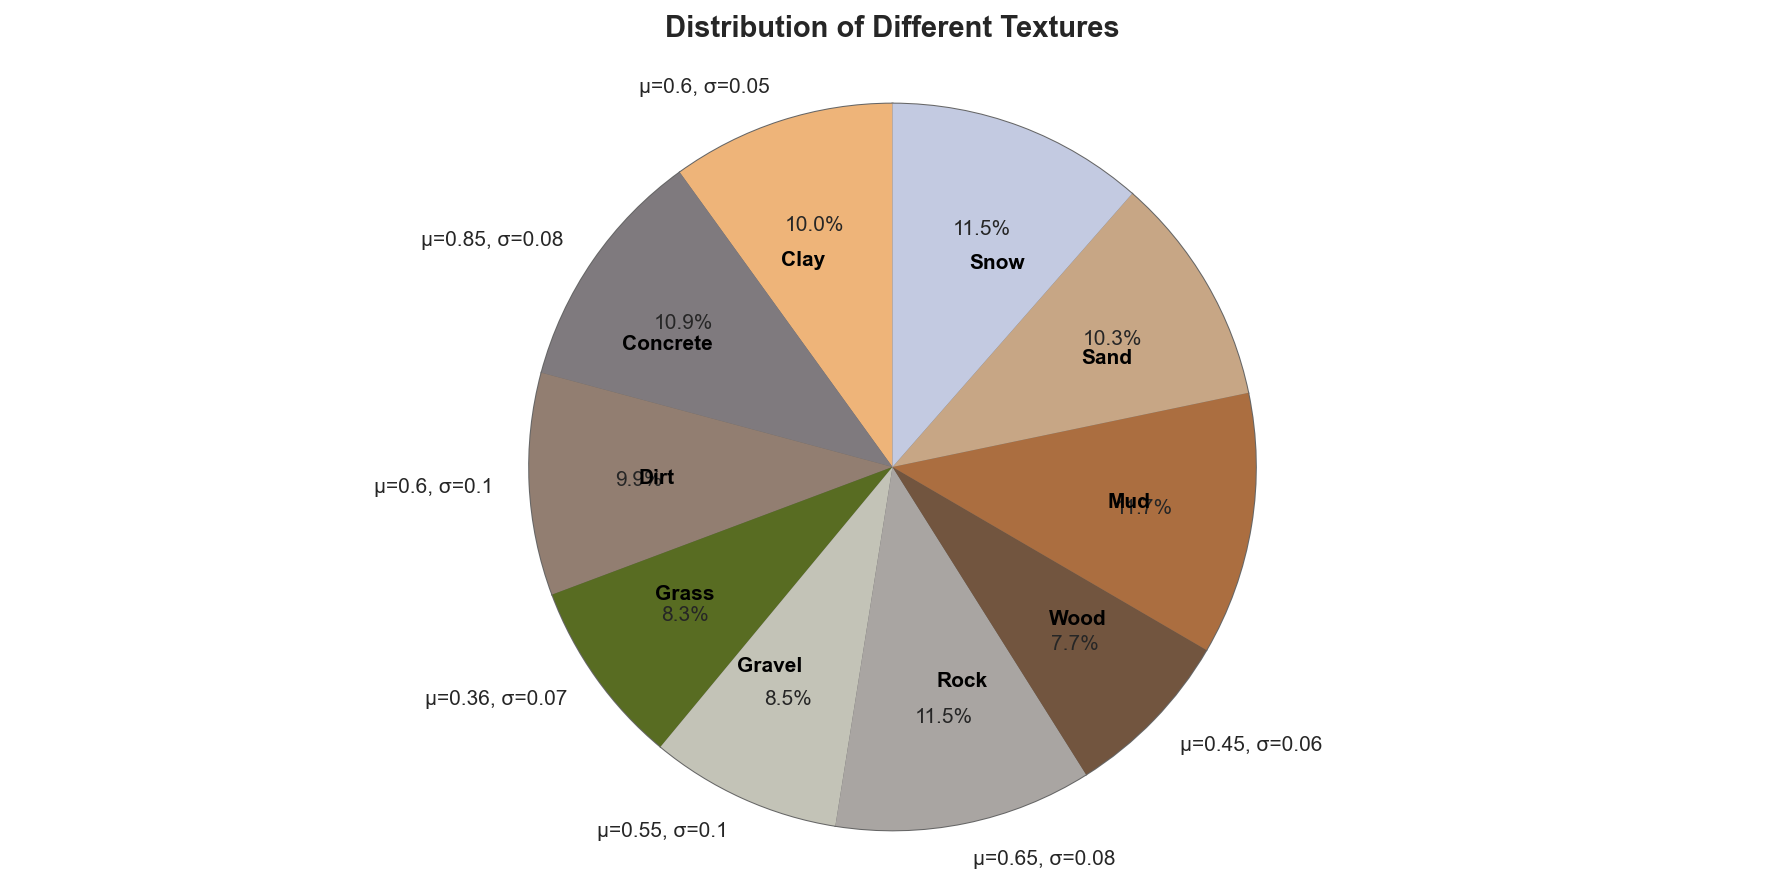

In [9]:
import os
import glob
import yaml
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Base directory and pattern
base_dir = os.getcwd()
config_pattern = os.path.join(base_dir, "../data/terrain_bitmaps/BenchMaps/sampled_maps/configTest/Final", "config*.yaml")
matched_files = glob.glob(config_pattern)

# Initialize counters
texture_counts = defaultdict(int)
terrain_type_counts = defaultdict(int)
total_textures = 0
total_configs = len(matched_files)

# Define texture types
rigid_types = ['clay', 'concrete', 'dirt', 'grass', 'gravel', 'rock', 'wood']
deformable_types = ['mud', 'sand', 'snow']

# For total distribution including mixed
total_rigid_count = 0
total_deform_count = 0

# Process each config file
for file_path in matched_files:
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
        
        # Count basic terrain types
        terrain_type = config['terrain_type']
        terrain_type_counts[terrain_type] += 1
        
        # Count textures and calculate true rigid/deformable distribution
        rigid_in_config = 0
        deform_in_config = 0
        
        textures = config['textures']
        for texture_info in textures:
            terrain_type = texture_info['terrain_type']
            is_deformable = texture_info['is_deformable']
            
            # Count individual texture types
            texture_counts[terrain_type] += 1
            total_textures += 1
            
            # Count as rigid or deformable
            if is_deformable:
                deform_in_config += 1
                total_deform_count += 1
            else:
                rigid_in_config += 1
                total_rigid_count += 1

# Calculate percentages
print("Original Terrain Type Distribution:")
print("-" * 50)
for terrain_type in terrain_type_counts:
    percentage = (terrain_type_counts[terrain_type] / total_configs) * 100
    print(f"{terrain_type}: {percentage:.2f}%")

print("\nTrue Rigid vs Deformable Distribution (including mixed):")
print("-" * 50)
total_all = total_rigid_count + total_deform_count
print(f"Rigid: {(total_rigid_count/total_all)*100:.2f}%")
print(f"Deformable: {(total_deform_count/total_all)*100:.2f}%")

print("\nDetailed Texture Distribution:")
print("-" * 50)
print("\nRigid Textures:")
for texture in rigid_types:
    percentage = (texture_counts[texture] / total_textures) * 100
    print(f"{texture}: {percentage:.2f}%")

print("\nDeformable Textures:")
for texture in deformable_types:
    percentage = (texture_counts[texture] / total_textures) * 100
    print(f"{texture}: {percentage:.2f}%")

# Visualization
plt.figure(figsize=(15, 5))

# # 1. Original terrain type distribution
# plt.subplot(131)
# terrain_labels = list(terrain_type_counts.keys())
# terrain_sizes = list(terrain_type_counts.values())
# plt.pie(terrain_sizes, labels=terrain_labels, autopct='%1.1f%%')
# plt.title('Original Terrain Type Distribution')

# # 2. True rigid/deformable distribution
# plt.subplot(132)
# true_dist = [total_rigid_count, total_deform_count]
# plt.pie(true_dist, labels=['Rigid', 'Deformable'], autopct='%1.1f%%')
# plt.title('True Rigid vs Deformable Distribution')

# 3. Individual texture distribution
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Create more compact figure
plt.figure(figsize=(12, 6), dpi=150)

NATURAL_COLORS = {
    'clay': '#eeb479',    
    'concrete': '#7f7a7e', 
    'dirt': '#927e71',    
    'grass': '#586c22',    
    'gravel': '#c3c3b7',   
    'rock': '#a9a5a2',    
    'wood': '#72553f',     
    'mud': '#ab6e40',      
    'sand': '#c7a685',     
    'snow': '#c3cae1'     
}

friction_properties = {
    'clay': (0.6, 0.05),    
    'concrete': (0.85, 0.08), 
    'dirt': (0.6, 0.1),     
    'grass': (0.36, 0.07),  
    'gravel': (0.55, 0.1),   
    'rock': (0.65, 0.08),   
    'wood': (0.45, 0.06)    
}

# Prepare data
inner_labels = [] 
outer_labels = []
sizes = []
colors = []

for texture in rigid_types + deformable_types:
    if texture_counts[texture] > 0:
        inner_labels.append(texture.capitalize())
        
        if texture in friction_properties:
            mean, std = friction_properties[texture]
            outer_labels.append(f'μ={mean}, σ={std}')
        else:
            outer_labels.append('')
            
        sizes.append((texture_counts[texture] / total_textures) * 100)
        colors.append(NATURAL_COLORS[texture])

plt.pie(sizes, 
        labels=outer_labels, 
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.7,    
        labeldistance=1.1,   
        wedgeprops={'edgecolor': '#666666', 'linewidth': 1},
        textprops={'fontsize': 10}
        )

plt.pie(sizes, 
        labels=inner_labels,  
        colors=colors,
        startangle=90,
        labeldistance=0.6,   
        wedgeprops={'edgecolor': 'none', 'linewidth': 0}, 
        textprops={'fontsize': 10, 'color': 'black', 'fontweight': 'bold'} 
        )

plt.title('Distribution of Different Textures', 
          fontsize=14, 
          fontweight='bold', 
          pad=15)

plt.axis('equal')
plt.tight_layout()
plt.show()

Original Terrain Type Distribution:
--------------------------------------------------
rigid: 60.00%
deformable: 30.00%
mixed: 10.00%

True Rigid vs Deformable Distribution (including mixed):
--------------------------------------------------
Rigid: 66.60%
Deformable: 33.40%

Detailed Texture Distribution:
--------------------------------------------------

Rigid Textures:
clay: 9.95%
concrete: 10.87%
dirt: 9.89%
grass: 8.27%
gravel: 8.50%
rock: 11.45%
wood: 7.66%

Deformable Textures:
mud: 11.67%
sand: 10.27%
snow: 11.46%


<Figure size 1500x500 with 0 Axes>

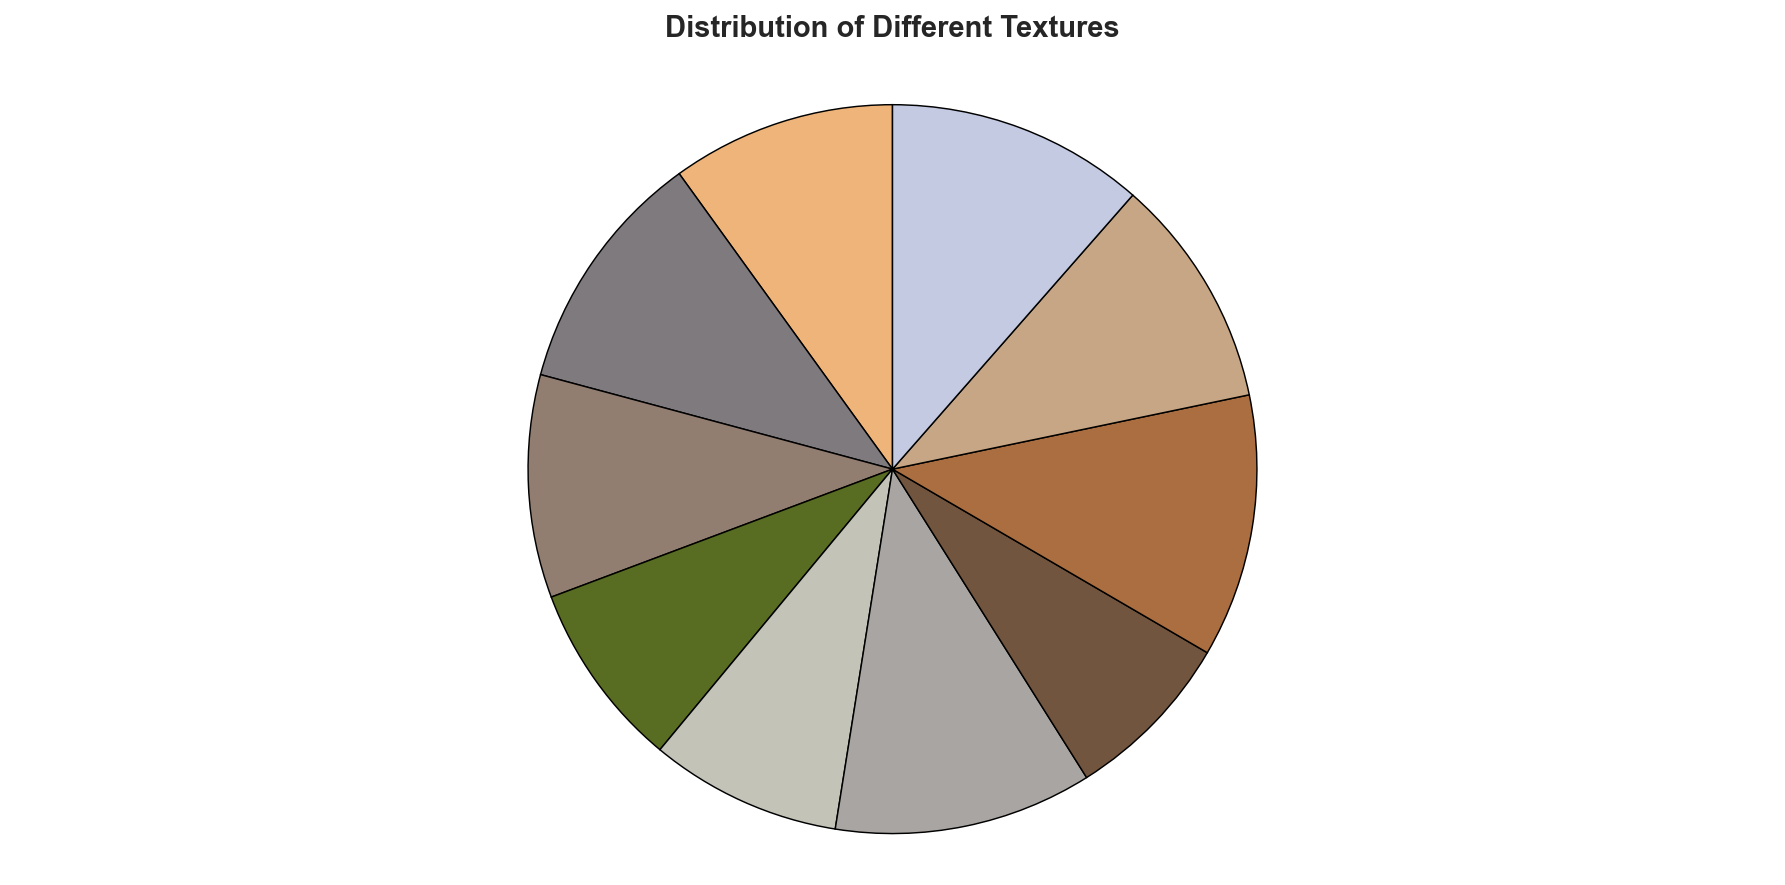

In [15]:
import os
import glob
import yaml
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Base directory and pattern
base_dir = os.getcwd()
config_pattern = os.path.join(base_dir, "../data/terrain_bitmaps/BenchMaps/sampled_maps/configTest/Final", "config*.yaml")
matched_files = glob.glob(config_pattern)

# Initialize counters
texture_counts = defaultdict(int)
terrain_type_counts = defaultdict(int)
total_textures = 0
total_configs = len(matched_files)

# Define texture types
rigid_types = ['clay', 'concrete', 'dirt', 'grass', 'gravel', 'rock', 'wood']
deformable_types = ['mud', 'sand', 'snow']

# For total distribution including mixed
total_rigid_count = 0
total_deform_count = 0

# Process each config file
for file_path in matched_files:
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
        
        # Count basic terrain types
        terrain_type = config['terrain_type']
        terrain_type_counts[terrain_type] += 1
        
        # Count textures and calculate true rigid/deformable distribution
        rigid_in_config = 0
        deform_in_config = 0
        
        textures = config['textures']
        for texture_info in textures:
            terrain_type = texture_info['terrain_type']
            is_deformable = texture_info['is_deformable']
            
            # Count individual texture types
            texture_counts[terrain_type] += 1
            total_textures += 1
            
            # Count as rigid or deformable
            if is_deformable:
                deform_in_config += 1
                total_deform_count += 1
            else:
                rigid_in_config += 1
                total_rigid_count += 1

# Calculate percentages
print("Original Terrain Type Distribution:")
print("-" * 50)
for terrain_type in terrain_type_counts:
    percentage = (terrain_type_counts[terrain_type] / total_configs) * 100
    print(f"{terrain_type}: {percentage:.2f}%")

print("\nTrue Rigid vs Deformable Distribution (including mixed):")
print("-" * 50)
total_all = total_rigid_count + total_deform_count
print(f"Rigid: {(total_rigid_count/total_all)*100:.2f}%")
print(f"Deformable: {(total_deform_count/total_all)*100:.2f}%")

print("\nDetailed Texture Distribution:")
print("-" * 50)
print("\nRigid Textures:")
for texture in rigid_types:
    percentage = (texture_counts[texture] / total_textures) * 100
    print(f"{texture}: {percentage:.2f}%")

print("\nDeformable Textures:")
for texture in deformable_types:
    percentage = (texture_counts[texture] / total_textures) * 100
    print(f"{texture}: {percentage:.2f}%")

# Visualization
plt.figure(figsize=(15, 5))

# # 1. Original terrain type distribution
# plt.subplot(131)
# terrain_labels = list(terrain_type_counts.keys())
# terrain_sizes = list(terrain_type_counts.values())
# plt.pie(terrain_sizes, labels=terrain_labels, autopct='%1.1f%%')
# plt.title('Original Terrain Type Distribution')

# # 2. True rigid/deformable distribution
# plt.subplot(132)
# true_dist = [total_rigid_count, total_deform_count]
# plt.pie(true_dist, labels=['Rigid', 'Deformable'], autopct='%1.1f%%')
# plt.title('True Rigid vs Deformable Distribution')

# 3. Individual texture distribution
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
 
# Create more compact figure
plt.figure(figsize=(12, 6), dpi=150)

NATURAL_COLORS = {
    'clay': '#eeb479',    
    'concrete': '#7f7a7e', 
    'dirt': '#927e71',    
    'grass': '#586c22',    
    'gravel': '#c3c3b7',   
    'rock': '#a9a5a2',    
    'wood': '#72553f',     
    'mud': '#ab6e40',      
    'sand': '#c7a685',     
    'snow': '#c3cae1'     
}

friction_properties = {
    'clay': (0.6, 0.05),    
    'concrete': (0.85, 0.08), 
    'dirt': (0.6, 0.1),     
    'grass': (0.36, 0.07),  
    'gravel': (0.55, 0.1),   
    'rock': (0.65, 0.08),   
    'wood': (0.45, 0.06)    
}

# Prepare data
sizes = []
colors = []

for texture in rigid_types + deformable_types:
    if texture_counts[texture] > 0:
        sizes.append((texture_counts[texture] / total_textures) * 100)
        colors.append(NATURAL_COLORS[texture])

plt.pie(sizes, 
        colors=colors,
        startangle=90,
        wedgeprops={'edgecolor': 'black', 'linewidth': 0.7}
        ) 

plt.title('Distribution of Different Textures', 
          fontsize=14, 
          fontweight='bold', 
          pad=15)

plt.axis('equal')
plt.tight_layout()
plt.show()